https://www.kaggle.com/competitions/vehicle/overview

In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
# Import library
import os
import shutil
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import ceil
from collections import Counter

In [3]:
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

In [4]:
import itertools
import tensorflow as tf 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import models, optimizers, regularizers

In [5]:
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_inception_v3

In [6]:
import tensorflow_hub as hub

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
path_train_orig='vehicle/train/trainset/'
path_test='vehicle/test/'

In [9]:
pd.DataFrame(os.listdir(path_train_orig)).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,Ambulance,Barge,Bicycle,Boat,Bus,Car,Cart,Caterpillar,Helicopter,Limousine,Motorcycle,Segway,Snowmobile,Tank,Taxi,Truck,Van


In [10]:
# make dataset
data=[]
for categories in os.listdir(path_train_orig):
    for img in os.listdir(path_train_orig+categories):
        data.append((path_train_orig+categories+'/'+img, categories, img))
                    
df_train=pd.DataFrame(data, columns=['data_path', 'class', 'imagen' ])
df_train.head()

,data_path,class,imagen
0,vehicle/train/trainset/Ambulance/000040_09.jpg,Ambulance,000040_09.jpg
1,vehicle/train/trainset/Ambulance/000050_10.jpg,Ambulance,000050_10.jpg
2,vehicle/train/trainset/Ambulance/000052_03.jpg,Ambulance,000052_03.jpg
3,vehicle/train/trainset/Ambulance/000057_04.jpg,Ambulance,000057_04.jpg
4,vehicle/train/trainset/Ambulance/000067_14.jpg,Ambulance,000067_14.jpg


In [11]:
# value count of class
df_train['class'].value_counts()

Boat           8695
Car            6781
Motorcycle     2986
Bus            2133
Truck          2033
Bicycle        1618
Van            1111
Taxi            748
Helicopter      668
Caterpillar     331
Tank            206
Barge           202
Segway          153
Ambulance       132
Snowmobile      123
Limousine        74
Cart             51
Name: class, dtype: int64

In [12]:
categories = df_train['class'].unique()
categories 

array(['Ambulance', 'Barge', 'Bicycle', 'Boat', 'Bus', 'Car', 'Cart',
       'Caterpillar', 'Helicopter', 'Limousine', 'Motorcycle', 'Segway',
       'Snowmobile', 'Tank', 'Taxi', 'Truck', 'Van'], dtype=object)

# Convolutional Neural Network (CNN)

In [13]:
# epochs
epochs_val = 100

# batch_size
batch_size_val = 16

# target_size
#224
target_size_val=(224,224)

# input_shape
input_shape_val = (target_size_val[0],target_size_val[1], 3)

## Data Generators

In [14]:
# Datagen and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=None,
    validation_split= 0.3)

test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
# Train / Validation - Data Generator
train_generator = train_datagen.flow_from_directory(path_train_orig,
                                 target_size=target_size_val,
                                 batch_size=batch_size_val,
                                 class_mode = 'categorical',
                                 subset = "training")

val_generator = train_datagen.flow_from_directory(path_train_orig,
                                 target_size=target_size_val,
                                 batch_size=batch_size_val,
                                 class_mode = 'categorical',
                                 subset = "validation")

# Test 
test_generator = test_datagen.flow_from_directory(path_test,
                                 target_size=target_size_val,
                                 shuffle = False)

Found 19641 images belonging to 17 classes.
Found 8404 images belonging to 17 classes.
Found 7958 images belonging to 1 classes.


In [16]:
# class_weight - Unbalanced Data

counter = Counter(train_generator.classes)                          
class_weights = dict(zip(list(counter.keys()),
                 class_weight.compute_class_weight('balanced', list(counter.keys()),train_generator.classes)))
class_weights

{0: 12.42314990512334,
 1: 8.136288318144159,
 2: 1.0197289860339547,
 3: 0.1898066274316528,
 4: 0.7733286085518545,
 5: 0.24338591556277028,
 6: 32.09313725490196,
 7: 4.979969574036511,
 8: 2.4687028657616894,
 9: 22.218325791855204,
 10: 0.5525360789940079,
 11: 10.697712418300654,
 12: 13.279918864097363,
 13: 7.967951318458418,
 14: 2.2048720251459364,
 15: 0.8113433575677462,
 16: 1.4850294873733556}

In [17]:
train_generator.classes

array([ 0,  0,  0, ..., 16, 16, 16], dtype=int32)

In [18]:
train_generator.class_indices

{'Ambulance': 0,
 'Barge': 1,
 'Bicycle': 2,
 'Boat': 3,
 'Bus': 4,
 'Car': 5,
 'Cart': 6,
 'Caterpillar': 7,
 'Helicopter': 8,
 'Limousine': 9,
 'Motorcycle': 10,
 'Segway': 11,
 'Snowmobile': 12,
 'Tank': 13,
 'Taxi': 14,
 'Truck': 15,
 'Van': 16}

In [19]:
train_generator_dict={y: x for x, y in train_generator.class_indices.items()}
train_generator_dict

{0: 'Ambulance',
 1: 'Barge',
 2: 'Bicycle',
 3: 'Boat',
 4: 'Bus',
 5: 'Car',
 6: 'Cart',
 7: 'Caterpillar',
 8: 'Helicopter',
 9: 'Limousine',
 10: 'Motorcycle',
 11: 'Segway',
 12: 'Snowmobile',
 13: 'Tank',
 14: 'Taxi',
 15: 'Truck',
 16: 'Van'}

Found 28045 images belonging to 17 classes.


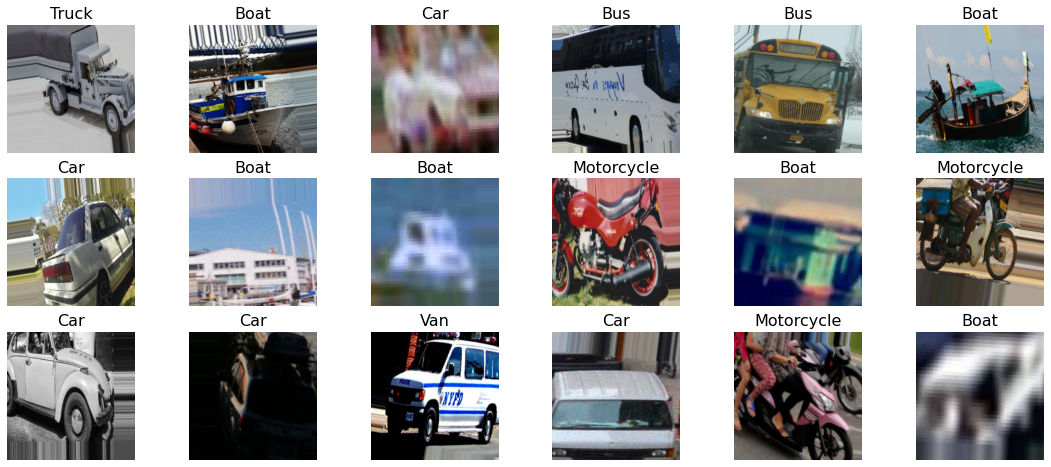

In [20]:
# plot image of train_generator_image

train_datagen_image = ImageDataGenerator(rescale=1./255)

train_generator_image = train_datagen.flow_from_directory(path_train_orig,
                                 target_size=target_size_val,
                                 batch_size=100)
plt.figure(figsize = (19, 8))
image_train_gen, cl = next(train_generator_image) # len(next(train_generator)) = batch_size
for i in range(18):
    ax=plt.subplot(3,6,i+1)
    im = image_train_gen[i]
    plt.imshow(im)
    plt.title(train_generator_dict[np.where(cl[i]==1)[0][0]],fontsize=16)
    plt.axis('off')

In [21]:
#module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
module_url = "https://tfhub.dev/google/bit/m-r50x1/1"

model_hub = tf.keras.Sequential([
                                 tf.keras.layers.InputLayer(input_shape=input_shape_val),
                                 hub.KerasLayer(module_url, trainable=False),
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(1024, activation ="relu"),
                                 tf.keras.layers.Dropout(rate=0.5),
                                 tf.keras.layers.Dense(len(train_generator.class_indices), activation = "softmax")
])

model_hub.build((None, input_shape_val))
# name
model_hub._name = "model_m-r50x1"
model_hub.summary()

2022-04-29 14:34:44.644483: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 14:34:44.658091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 14:34:44.658420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 14:34:44.659313: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model_m-r50x1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 17)                17425     
                                                                 
Total params: 25,615,953
Trainable params: 2,115,601
Non-trainable params: 23,500,352
_________________________________________________________________


In [22]:
def plot_model_output(history, name='model'):
    
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    accuracy_values = history_dict['accuracy']
    val_accuracy_values = history_dict['val_accuracy']
    
    fig = plt.figure(figsize=(19,3))
    
    plt.subplot(1, 2, 1)
    plt.suptitle(name, fontsize=18)
    plt.title('loss')
    epoch = range(1,len(loss_values)+1)
    plt.plot(epoch,loss_values, '--',label='loss')
    plt.plot(epoch,val_loss_values, '--',label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(1, 2, 2)
    plt.suptitle(name, fontsize=18)
    plt.title('accuracy')
    epoch = range(1,len(loss_values)+1)
    plt.plot(epoch,accuracy_values, '--',label='accuracy')
    plt.plot(epoch,val_accuracy_values, '--',label='val_accuracy')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

In [23]:
if os.path.exists('models/'):
    pass
else:
    os.makedirs('models/')

In [24]:
# Define optimizer
optimizer = optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [25]:
# callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8) 

In [26]:
# run models fuction

filepath=os.getcwd()+'/models/'
def run_model(model):
    
    # save best model (callback)
    modelCheckpoint = ModelCheckpoint(filepath+'{}.h5'.format(model.name), save_best_only = True)
    
    # Compile the model
    model.compile(optimizer = optimizer , loss = 'categorical_crossentropy', metrics=["accuracy"])
    
    # Fit the model
    history = model.fit_generator(generator=train_generator,
                              epochs = epochs_val,
                              steps_per_epoch=300,
                              validation_steps = 100,
                              callbacks=[early_stopping, rlr, modelCheckpoint],
                              class_weight=class_weights,
                              validation_data = val_generator)
    
    print(history.history.keys())
    
    return model, history

In [27]:
max_accuracy=[]

In [28]:
# Run model 
#tf.keras.backend.clear_session()
model_mr50x1, history_mr50x1 = run_model(model_hub)
max_accuracy.append(('{}.h5'.format(model_hub.name),np.max(history_mr50x1.history['accuracy'])))

Epoch 1/100


2022-04-29 14:35:07.948468: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-04-29 14:35:10.031178: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


300/300 [==============================] - 255s 806ms/step - loss: 6.1026 - accuracy: 0.3837 - val_loss: 1.5248 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 2/100
300/300 [==============================] - 244s 812ms/step - loss: 1.8505 - accuracy: 0.5483 - val_loss: 0.7167 - val_accuracy: 0.7725 - lr: 0.0010
Epoch 3/100
300/300 [==============================] - 250s 832ms/step - loss: 1.4133 - accuracy: 0.5121 - val_loss: 1.0797 - val_accuracy: 0.6381 - lr: 0.0010
Epoch 4/100
300/300 [==============================] - 252s 839ms/step - loss: 1.4106 - accuracy: 0.5250 - val_loss: 1.0273 - val_accuracy: 0.6900 - lr: 0.0010
Epoch 5/100
300/300 [==============================] - 253s 843ms/step - loss: 1.4053 - accuracy: 0.5331 - val_loss: 1.0286 - val_accuracy: 0.6631 - lr: 0.0010
Epoch 6/100
300/300 [==============================] - 253s 844ms/step - loss: 1.2011 - accuracy: 0.5779 - val_loss: 1.2575 - val_accuracy: 0.5456 - lr: 0.0010
Epoch 7/100
300/300 [==============================]

300/300 [==============================] - 263s 876ms/step - loss: 0.4899 - accuracy: 0.7331 - val_loss: 0.5746 - val_accuracy: 0.7987 - lr: 1.0000e-04
Epoch 52/100
300/300 [==============================] - 264s 880ms/step - loss: 0.4670 - accuracy: 0.7523 - val_loss: 0.5591 - val_accuracy: 0.8206 - lr: 1.0000e-04
Epoch 53/100
300/300 [==============================] - 263s 876ms/step - loss: 0.4721 - accuracy: 0.7406 - val_loss: 0.6403 - val_accuracy: 0.7738 - lr: 1.0000e-04
Epoch 54/100
300/300 [==============================] - 262s 874ms/step - loss: 0.5281 - accuracy: 0.7460 - val_loss: 0.5502 - val_accuracy: 0.8188 - lr: 1.0000e-04
Epoch 55/100
300/300 [==============================] - 262s 873ms/step - loss: 0.4637 - accuracy: 0.7621 - val_loss: 0.5837 - val_accuracy: 0.8050 - lr: 1.0000e-05
Epoch 56/100
300/300 [==============================] - 260s 868ms/step - loss: 0.4735 - accuracy: 0.7648 - val_loss: 0.5057 - val_accuracy: 0.8194 - lr: 1.0000e-05
Epoch 57/100
300/300 [=

In [29]:
max_accuracy.append(('{}.h5'.format(model_hub.name),np.max(history_mr50x1.history['accuracy'])))

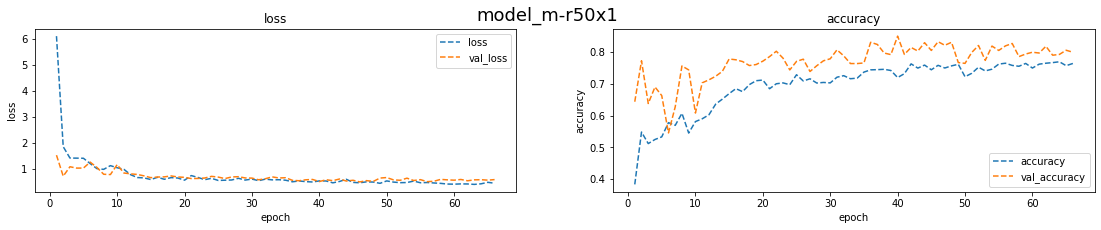

In [30]:
# plot model ouputs
plot_model_output(history_mr50x1, 'model_m-r50x1')

In [31]:
# load best model
load_model = tf.keras.models.load_model('models/model_m-r50x1.h5',custom_objects={'KerasLayer':hub.KerasLayer})
load_model

In [32]:
filenames = test_generator.filenames
filenames[0:3]

['testset/000000.jpg', 'testset/000001.jpg', 'testset/000002.jpg']

In [33]:
predictions = load_model.predict(test_generator)

2022-04-29 19:17:59.917605: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-29 19:18:00.542359: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-29 19:18:01.115018: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-29 19:18:01.197890: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

In [34]:
predictions[0]

array([9.2279454e-16, 4.5684536e-04, 2.5531806e-08, 9.9954271e-01,
       1.7779092e-11, 1.9163105e-07, 2.4891351e-09, 1.6330726e-12,
       2.0644377e-07, 8.2432092e-13, 2.1349157e-11, 2.3487712e-10,
       1.1269367e-12, 2.8115693e-12, 7.4966427e-13, 2.4071532e-08,
       1.7507075e-09], dtype=float32)

In [35]:
train_generator_dict[8]

'Helicopter'

In [36]:
pred_class_name=[]
for i in range(len(predictions)):
    pred=np.argmax(predictions[i])
    pred_class_name.append(train_generator_dict[pred])
    
pred_class_name[0:3]

['Boat', 'Van', 'Car']

### submission

In [37]:
submission_df=pd.DataFrame(pred_class_name, test_generator.filenames).reset_index()
submission_df.columns=['Id','Category']
submission_df['Id']=submission_df['Id'].apply(lambda x: x.split('/')[1])
submission_df.head(3)

,Id,Category
0,000000.jpg,Boat
1,000001.jpg,Van
2,000002.jpg,Car


In [38]:
submission_df['Category'].to_csv('submission.csv',index=True, header=True)